<a href="https://colab.research.google.com/github/Udaykirank2611/Crime_Classification/blob/main/CrimeCastClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'crime-cast-forecasting-crime-categories:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77420%2F8446444%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240714%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240714T121213Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1e9ee5bebec4254fee996df40841ce7a830e99e23828c201b0007afba3e407f0a61c221f785546e9930a3966c69160b6ab180e8f28f7aa5fa8f2e8ea107c1809617ffcfe5f9db883ef9f5bad540fe130fadc5a7c3a989ba84078a79d8a7fe63f2ff14d98890b934f1cb2d19d6c31fc03263e8bb010ae0fb6984eccc56a95bbccbeafc879c353ab1d6f171bac7955bbc4e22d2c01bef363e8686963af0a0e262ec51cf599d5a2010ed2f6a851f74ee992c81007c2560d21313454d446e8a6f29452081936823bb1f11690ea9f3220c979d85fd8f4a64ca88f195491c06c206b441f6fc8e504ac0d5377ef61c0b9109e4a3f956ecc196606868f75ee23d25c1e37'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1103010 bytes downloaded
Downloaded and uncompressed: crime-cast-forecasting-crime-categories
Data source import complete.


# ***IMPORTING PACKAGES***

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble  import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv


# ***IMPORTING DATA***

In [ ]:
df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
sample = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv")
x_test = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/test.csv")

# ***Exploratory Data Analysis(EDA)***

In [ ]:
df.shape

(20000, 22)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [ ]:
df.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [ ]:
df.tail()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
19995,5100 W ADAMS BL,NaN,34.0334,-118.3523,05/24/2020 12:00:00 AM,05/24/2020 12:00:00 AM,700.0,3.0,Southwest,303.0,...,51.0,M,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Violent Crimes
19996,16900 ROSCOE BL,NaN,34.2212,-118.5011,12/25/2020 12:00:00 AM,12/25/2020 12:00:00 AM,259.0,10.0,West Valley,1008.0,...,0.0,M,W,301.0,GAS STATION,NaN,NaN,IC,Invest Cont,Property Crimes
19997,1000 S SHENANDOAH ST,NaN,34.0571,-118.3815,09/25/2020 12:00:00 AM,09/25/2020 12:00:00 AM,1400.0,8.0,West LA,849.0,...,42.0,M,H,102.0,SIDEWALK,NaN,NaN,IC,Invest Cont,Property Crimes
19998,300 W SEPULVEDA ST,NaN,33.7451,-118.2835,06/10/2020 12:00:00 AM,06/10/2020 12:00:00 AM,600.0,5.0,Harbor,558.0,...,76.0,F,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Crimes against Public Order
19999,DALTON AV,VERNON AV,34.0037,-118.3034,02/18/2020 12:00:00 AM,02/17/2020 12:00:00 AM,1800.0,3.0,Southwest,397.0,...,0.0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes


In [ ]:
for x in df:
    print(x," : ",df[x].nunique())

Location  :  12399
Cross_Street  :  1495
Latitude  :  3622
Longitude  :  3578
Date_Reported  :  811
Date_Occurred  :  366
Time_Occurred  :  996
Area_ID  :  21
Area_Name  :  21
Reporting_District_no  :  1120
Part 1-2  :  2
Modus_Operandi  :  10489
Victim_Age  :  100
Victim_Sex  :  4
Victim_Descent  :  17
Premise_Code  :  217
Premise_Description  :  216
Weapon_Used_Code  :  57
Weapon_Description  :  57
Status  :  5
Status_Description  :  5
Crime_Category  :  6


In [ ]:
df.isna().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

In [ ]:
df.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


# ***MAKING HOMOGENOUS DATA***

In [ ]:
df['Victim_Sex'].fillna('Missing')


0              M
1              M
2              M
3              M
4              X
          ...   
19995          M
19996          M
19997          M
19998          F
19999    Missing
Name: Victim_Sex, Length: 20000, dtype: object

In [ ]:
lb = LabelEncoder()
df['Crime_encoded'] = lb.fit_transform(df['Crime_Category'])
mapping=dict(zip(df['Crime_encoded'],df['Crime_Category']))
df['Sex_encoded'] = lb.fit_transform(df['Victim_Sex'])
x_test['Sex_encoded'] = lb.fit_transform(x_test['Victim_Sex'])
df['Area_id_en'] = lb.fit_transform(df['Area_ID'])
x_test['Area_id_en'] = lb.fit_transform(x_test['Area_ID'])
df['Area_name_en'] = lb.fit_transform(df['Area_Name'])
x_test['Area_name_en'] = lb.fit_transform(x_test['Area_Name'])
df['Weapon_Used_Code_en'] = lb.fit_transform(df['Weapon_Used_Code'])
x_test['Weapon_Used_Code_en'] = lb.fit_transform(x_test['Weapon_Used_Code'])
df['Weapon_Description_en'] = lb.fit_transform(df['Weapon_Description'])
x_test['Weapon_Description_en'] = lb.fit_transform(x_test['Weapon_Description'])
df['Status_en'] = lb.fit_transform(df['Status'])
x_test['Status_en'] = lb.fit_transform(x_test['Status'])
df['Status_Description_en'] = lb.fit_transform(df['Status_Description'])
x_test['Status_Description_en'] = lb.fit_transform(x_test['Status_Description'])
df['Part 1-2_en'] = lb.fit_transform(df['Part 1-2'])
x_test['Part 1-2_en'] = lb.fit_transform(x_test['Part 1-2'])
df['Victim_Descent_en'] = lb.fit_transform(df['Victim_Descent'])
x_test['Victim_Descent_en'] = lb.fit_transform(x_test['Victim_Descent'])
df['Victim_Age_en'] = lb.fit_transform(df['Victim_Age'])
x_test['Victim_Age_en'] = lb.fit_transform(x_test['Victim_Age'])
df['Victim_Sex_en'] = lb.fit_transform(df['Victim_Sex'])
x_test['Victim_Sex_en'] = lb.fit_transform(x_test['Victim_Sex'])
df['Premise_Code_en'] = lb.fit_transform(df['Premise_Code'])
x_test['Premise_Code_en'] = lb.fit_transform(x_test['Premise_Code'])
df['Premise_Description_en'] = lb.fit_transform(df['Premise_Description'])
x_test['Premise_Description_en'] = lb.fit_transform(x_test['Premise_Description'])
#labels = df["Crime_encoded"]

# ***KNN IMPUTER***

In [ ]:
imputer1 = KNNImputer()

In [ ]:
x = ["Victim_Sex_en","Crime_encoded"]
df['Victim_Sex_en'].replace('Missing', np.nan)
df[x] = imputer1.fit_transform(df[x])

# ***DELETING EXTRA FEATURES***

In [ ]:
a = ["Crime_Category"]
drop1 =["Cross_Street","Victim_Sex","Location","Date_Reported"
        ,"Date_Occurred","Time_Occurred","Area_ID","Area_Name"
       ,"Weapon_Used_Code","Weapon_Description","Status","Status_Description"
       ,"Latitude","Longitude","Reporting_District_no","Modus_Operandi"
       ,"Part 1-2","Victim_Descent","Victim_Age",
        "Premise_Code","Premise_Description","Status_en"]
drop2 = drop1+a
df = df.drop(drop2,axis=1)
x_test = x_test.drop(drop1,axis=1)

<Axes: >

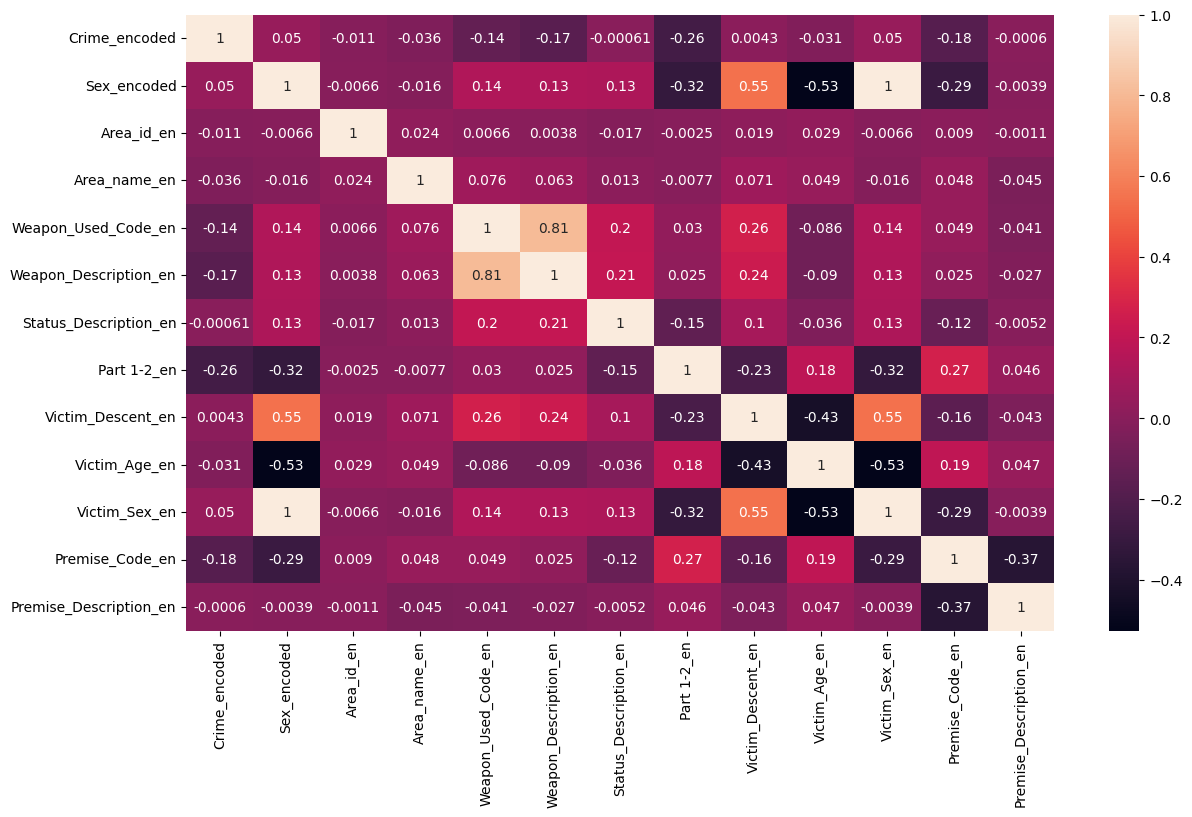

In [ ]:
cor = df.corr()
plt.figure(figsize = (14,8))
sns.heatmap(cor,annot=True)

# ***SPLITTING THE DATA***

In [ ]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.10,random_state=42)
for train_t,test_t in split.split(df,df["Crime_encoded"]):
    st_train = df.loc[train_t]
    st_test = df.loc[test_t]

# ***DIVIDING INTO TEST AND TRAIN***

In [ ]:
st_train_x = df.drop("Crime_encoded",axis=1)
st_train_y = df["Crime_encoded"]
st_test_x = st_test.drop("Crime_encoded",axis=1)
st_test_y = st_test["Crime_encoded"]

# ***DUMMY MODEL***

In [ ]:
from sklearn.dummy import DummyClassifier
model = DummyClassifier(strategy="most_frequent")
model.fit(st_train_x,st_train_y)
te_pre0 = model.predict(st_test_x)
acc=accuracy_score(st_test_y, te_pre0)
acc

0.5835

# ***FIRST MODEL MLP CLASSIFIER***

In [ ]:
model1 = MLPClassifier()
model1.fit(st_train_x,st_train_y)
te_pre1 = model1.predict(st_test_x)
acc=accuracy_score(st_test_y, te_pre1)
acc

0.8205

# ***SECOND MODEL RANDOM FOREST***

In [ ]:
model2 = RandomForestClassifier()
model2.fit(st_train_x,st_train_y)
te_pre2 = model2.predict(st_test_x)
acc=accuracy_score(st_test_y, te_pre2)
acc

0.994

In [ ]:
model2 = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(st_train_x, st_train_y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")
best_rf = grid_search.best_estimator_
test_accuracy = accuracy_score(st_test_y, best_rf.predict(st_test_x))
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.8606
Test Set Accuracy: 0.8955


# ***THIRD MODEL SVC***

In [ ]:
model3 = SVC()
model3.fit(st_train_x,st_train_y)
te_pre3 = model3.predict(st_test_x)
acc=accuracy_score(st_test_y, te_pre3)
acc

0.754

In [ ]:
model3 = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1e-3, 1e-4, 1e-5],
    'kernel': ['rbf']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(st_train_x, st_train_y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")
best_svm = grid_search.best_estimator_
test_accuracy = accuracy_score(st_test_y, best_svm.predict(st_test_x))
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Best Hyperparameters: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8280
Test Set Accuracy: 0.8430


# ***FOURTH MODEL KNNCLASSIFIER***

In [ ]:
model4 = KNeighborsClassifier()
model4.fit(st_train_x,st_train_y)
te_pre4 = model4.predict(st_test_x)
acc=accuracy_score(st_test_y, te_pre4)
acc

0.822

In [ ]:
model4 = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
}
grid_search = GridSearchCV(model4, param_grid, cv=5, scoring='accuracy')
grid_search.fit(st_train_x, st_train_y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")
best_knn = grid_search.best_estimator_
test_accuracy = accuracy_score(st_test_y, best_knn.predict(st_test_x))
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Best Hyperparameters: {'n_neighbors': 13}
Best Cross-Validation Accuracy: 0.7637
Test Set Accuracy: 0.7990
